# Package Releases Lookahead Metrics

## Setup

In [1]:
import re
from pathlib import Path

import seaborn as sns
import opinionated  # noqa
import colormaps as cmaps
import matplotlib.pyplot as plt
import polars as pl

plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Data dir
data_dir = (
    Path("~/active/dg-uoi-analysis/data/per-day-pkg-releases-metrics")
    .expanduser()
    .resolve()
    .absolute()
)

# Lazy read parquet files (all files in dir via glob)
lazy_frame = pl.scan_parquet(source=data_dir / "*")

# Lowercase all column names
lazy_frame = lazy_frame.select(pl.all().reverse().name.to_lowercase())

# Tame a random sample
lazy_frame.head(5).collect()

repo_created_date,package_managers,package_version,package_major_version,package_minor_version,package_patch_version,release_type,publish_datetime,publish_date,num_dependencies,num_stars_day_of_release,num_public_forks_day_of_release,num_dependents_on_release_date,num_dependents_plus_90_days,num_stars_plus_90_days,num_forks_plus_90_days,num_dependents_plus_180_days,num_stars_plus_180_days,num_forks_plus_180_days,num_dependents_plus_270_days,num_stars_plus_270_days,num_forks_plus_270_days,num_dependents_plus_360_days,num_stars_plus_360_days,num_forks_plus_360_days,normalized_package_manager,package_uuid
str,str,str,i64,i64,f64,str,datetime[ns],str,i64,i64,i64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,str,str
"""2018-05-31""","""rubygems""","""3.2.6""",3,2,6.0,"""patch""",2023-07-27 07:00:00,"""2023-07-27""",3,110,47,59567.0,59485,113.0,47.0,59493,114.0,50.0,59460,122.0,46.0,59388,134.0,57.0,"""rubygems""","""7521ddc9-bd2a-4efb-8038-d2154c…"
"""2014-06-15""","""npm""","""5.1.0""",5,1,0.0,"""minor""",2023-07-27 23:41:46,"""2023-07-27""",8,100,49,15.0,21,106.0,50.0,24,109.0,53.0,28,118.0,53.0,28,123.0,55.0,"""npm""","""24d548fd-cd39-472c-aac1-7fb4c0…"
"""2016-01-15""","""npm; rust""","""0.20.2""",0,20,2.0,"""zero-minor""",2023-07-27 10:22:56,"""2023-07-27""",7,182,57,43.0,43,202.0,64.0,47,220.0,67.0,51,239.0,73.0,48,256.0,79.0,"""multilingual""","""fae5aa93-6d98-41b6-b77b-0ef0ff…"
"""2017-01-01""","""rust""","""0.6.0""",0,6,0.0,"""zero-major""",2023-07-27 18:34:30,"""2023-07-27""",11,116,39,14.0,12,121.0,39.0,12,127.0,41.0,12,129.0,42.0,12,135.0,44.0,"""rust""","""0a273c11-9207-48a8-870a-605419…"
"""2019-03-02""","""rust""","""0.7.2""",0,7,2.0,"""zero-minor""",2023-07-27 01:47:49,"""2023-07-27""",12,104,13,13.0,13,108.0,13.0,14,111.0,15.0,14,114.0,15.0,14,118.0,18.0,"""rust""","""23dcc8e4-5893-4332-815b-fc0d9f…"


In [3]:
# Compute number of unique packages
num_unique_packages = len(lazy_frame.select("package_uuid").unique().collect())
print(f"Number of unique packages: {num_unique_packages}")

Number of unique packages: 21244


## Demographics

### Package Releases by Ecosystem

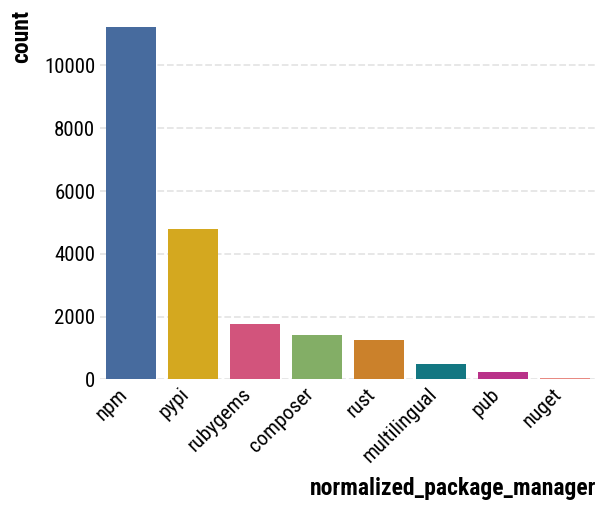

In [4]:
# Count plot of package manager
ecosystem_counts = (
    lazy_frame.unique(subset="package_uuid", keep="first")
    .select(pl.col("normalized_package_manager").value_counts(sort=True))
    .collect()
    .unnest("normalized_package_manager")
).top_k(8, by="count")

_ = sns.barplot(
    data=ecosystem_counts,
    x="normalized_package_manager",
    y="count",
    hue="normalized_package_manager",
)
_ = plt.xticks(rotation=45, ha="right")

### Package Releases by Release Type

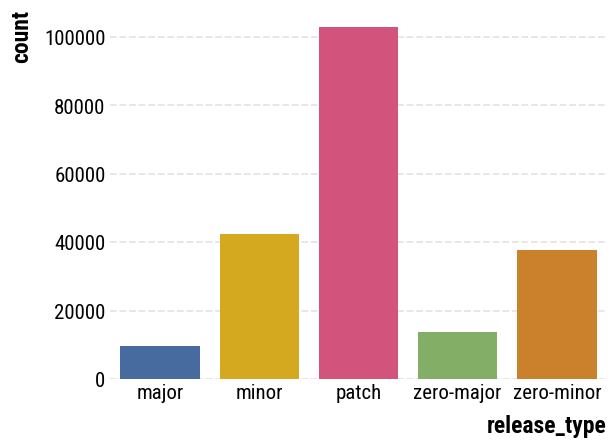

In [5]:
release_type_counts = (
    lazy_frame.filter(pl.col("release_type") != "unknown")
    .select(pl.col("release_type").value_counts())
    .unnest("release_type")
    .sort(by="release_type")
    .collect()
)

# Plot count of release types
_ = sns.barplot(
    data=release_type_counts,
    x="release_type",
    y="count",
    hue="release_type",
)

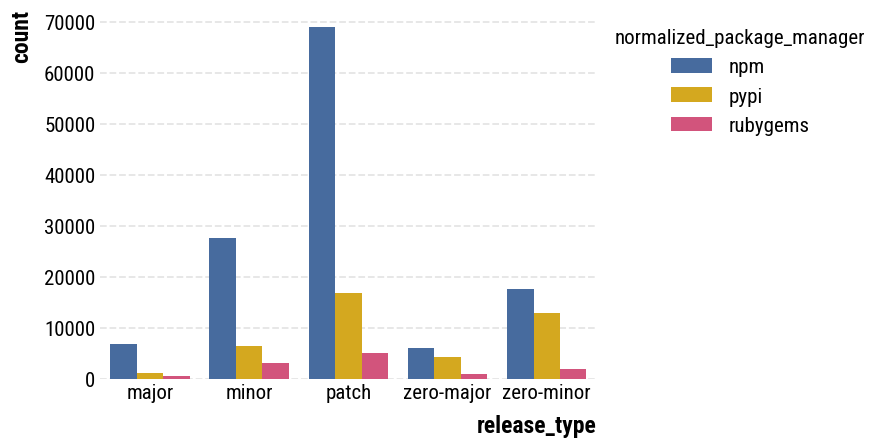

In [6]:
ecosystem_releases_counts = (
    lazy_frame.select(pl.col(["normalized_package_manager", "release_type"]))
    .filter(pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"]))
    .filter(pl.col("release_type") != "unknown")
    .group_by(pl.all())
    .len(name="count")
    .sort(by=["normalized_package_manager", "release_type"])
    .collect()
)

ax = sns.barplot(
    data=ecosystem_releases_counts,
    x="release_type",
    y="count",
    hue="normalized_package_manager",
    hue_order=["npm", "pypi", "rubygems"],
)

# Move legend outside of plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Distribution of Release Day Dependent Counts by Ecosystem

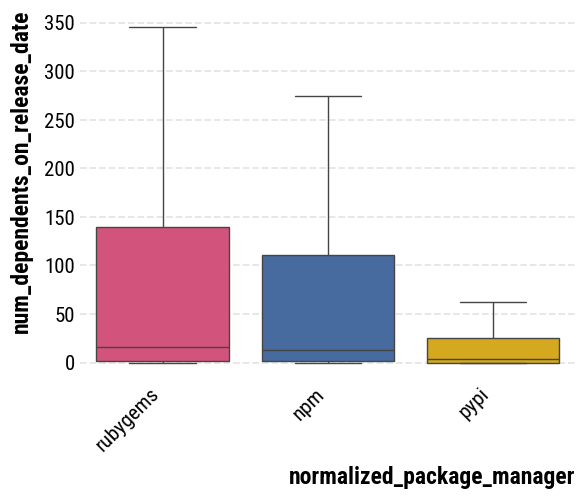

In [7]:
sns.boxplot(
    data=lazy_frame.select(
        pl.col("normalized_package_manager"),
        pl.col("num_dependents_on_release_date"),
    )
    .filter(pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"]))
    .collect(),
    x="normalized_package_manager",
    y="num_dependents_on_release_date",
    hue="normalized_package_manager",
    hue_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

_ = plt.xticks(rotation=45, ha="right")

In [8]:
lazy_frame.select(
    pl.col("normalized_package_manager"),
    pl.col("num_dependents_on_release_date"),
).group_by(pl.col("normalized_package_manager"),).quantile(0.5).filter(
    pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_dependents_on_release_date", descending=True
)

normalized_package_manager,num_dependents_on_release_date
str,f64
"""rubygems""",16.0
"""npm""",13.0
"""pypi""",4.0


In [9]:
lazy_frame.select(
    pl.col("normalized_package_manager"),
    pl.col("num_dependents_on_release_date"),
).group_by(pl.col("normalized_package_manager"),).quantile(0.75).filter(
    pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_dependents_on_release_date", descending=True
)

normalized_package_manager,num_dependents_on_release_date
str,f64
"""rubygems""",140.0
"""npm""",111.0
"""pypi""",25.0


### Distribution of Release Day Star Counts by Release Type

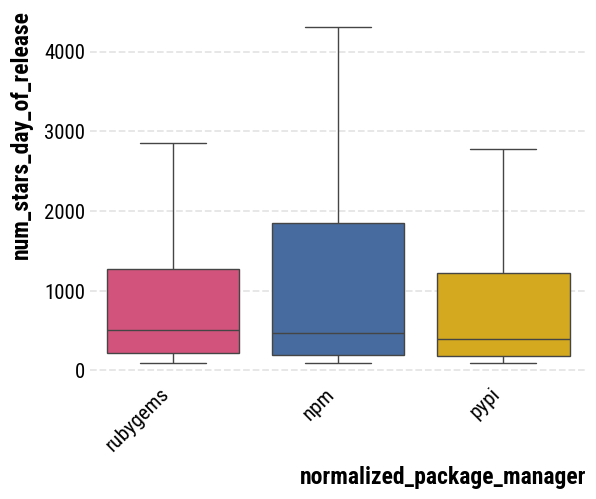

In [10]:
sns.boxplot(
    data=lazy_frame.select(
        pl.col("normalized_package_manager"),
        pl.col("num_stars_day_of_release"),
    )
    .filter(pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"]))
    .collect(),
    x="normalized_package_manager",
    y="num_stars_day_of_release",
    hue="normalized_package_manager",
    hue_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

_ = plt.xticks(rotation=45, ha="right")

In [11]:
lazy_frame.select(
    pl.col("normalized_package_manager"),
    pl.col("num_stars_day_of_release"),
).group_by(pl.col("normalized_package_manager"),).quantile(0.10).filter(
    pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_stars_day_of_release", descending=True
)

normalized_package_manager,num_stars_day_of_release
str,f64
"""rubygems""",133.0
"""npm""",130.0
"""pypi""",125.0


In [12]:
lazy_frame.select(
    pl.col("normalized_package_manager"),
    pl.col("num_stars_day_of_release"),
).group_by(pl.col("normalized_package_manager"),).quantile(0.25).filter(
    pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_stars_day_of_release", descending=True
)

normalized_package_manager,num_stars_day_of_release
str,f64
"""rubygems""",222.0
"""npm""",199.0
"""pypi""",179.0


## Look Ahead Metrics

### Log Difference in Stars by Package Ecosystem

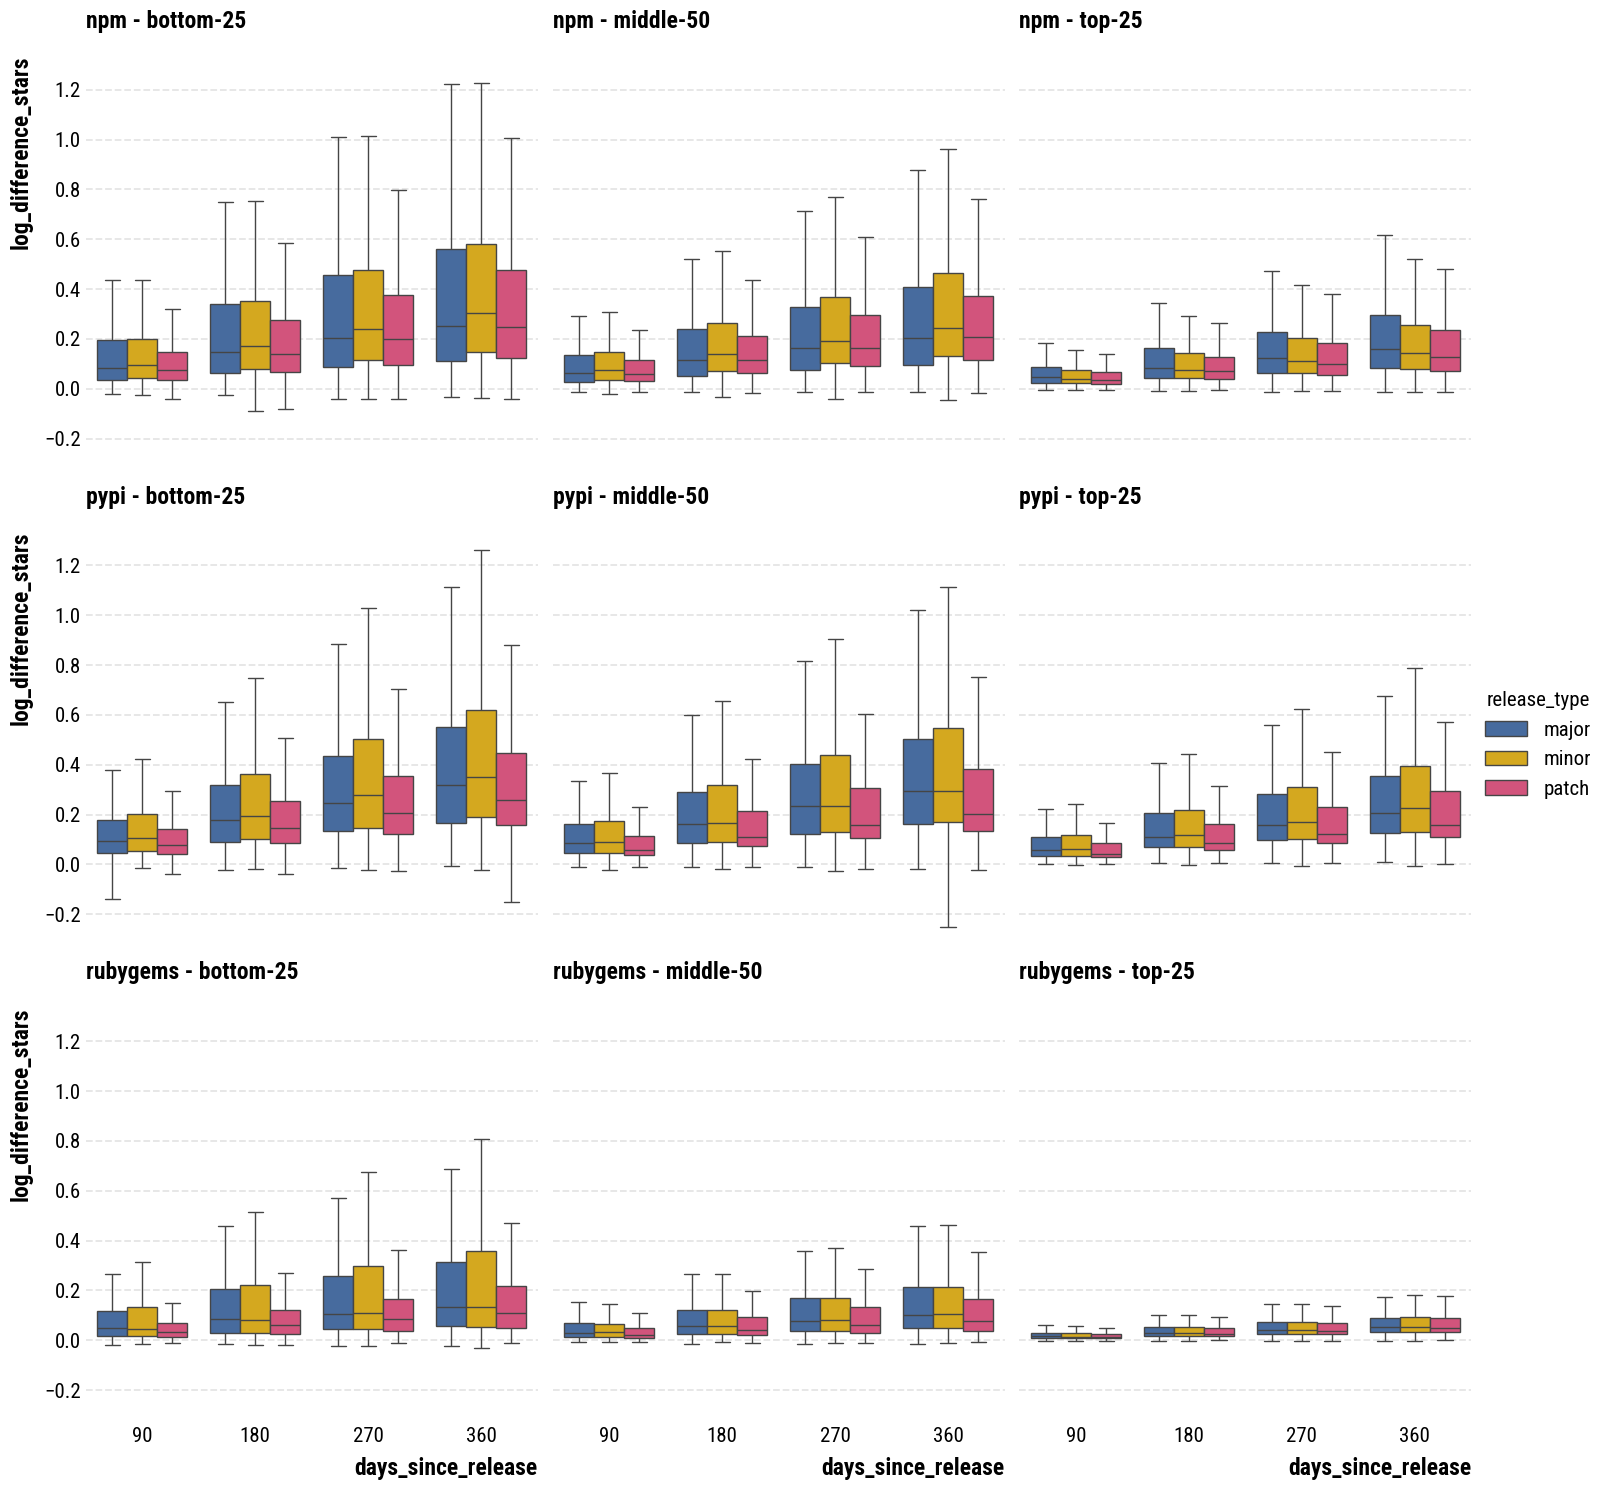

In [13]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_stars_" in col_name
]

# Calculate log difference in stars
constructed_exprs = []
for col_name in selected_columns:
    # Ignore the 0 day
    if col_name == "num_stars_day_of_release":
        continue

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                pl.when(pl.col("num_stars_day_of_release").gt(pl.lit(0)))
                .then(
                    (pl.col(col_name).log() - pl.col("num_stars_day_of_release").log())
                )
                .otherwise(
                    pl.lit(0),
                )
            ).alias(f"log_difference_stars_{timedelta_int}_days")
        )

# Create new column for log difference stars
log_diff_stars_ecosystem_release_type = (
    lazy_frame.filter(
        pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"])
    )
    .filter(pl.col("release_type") != "unknown")
    .filter(pl.col("num_stars_day_of_release").gt(pl.lit(50)))
    .select(
        pl.col("package_uuid"),
        pl.col("package_version"),
        pl.col("package_major_version"),
        pl.col("normalized_package_manager"),
        pl.col("release_type"),
        # Quantile bins for num_dependents
        pl.col("num_stars_day_of_release")
        .qcut(
            [0.25, 0.75],
            labels=["bottom-25", "middle-50", "top-25"],
        )
        .over("normalized_package_manager")
        .alias("num_stars_quantile"),
        *constructed_exprs,
    )
    .unpivot(
        index=[
            "package_uuid",
            "normalized_package_manager",
            "release_type",
            "package_version",
            "package_major_version",
            "num_stars_quantile",
        ],
        variable_name="days_since_release",
        value_name="log_difference_stars",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(
            r"^(log_difference_stars_)(\d+)(_days)$",
            r"$2",
        )
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

# Last step is to replace zero-major and zero-minor specifically for this plot
log_diff_stars_ecosystem_release_type_replaced_zero_ver = (
    log_diff_stars_ecosystem_release_type.select(
        pl.all().exclude("release_type"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
    )
)

# Plot pct growth dependents
g = sns.catplot(
    data=log_diff_stars_ecosystem_release_type_replaced_zero_ver,
    x="days_since_release",
    y="log_difference_stars",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="normalized_package_manager",
    row_order=["npm", "pypi", "rubygems"],
    col="num_stars_quantile",
    col_order=["bottom-25", "middle-50", "top-25"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

# # Move legend to within plot, in the lower right
# sns.move_legend(g, "lower right", bbox_to_anchor=(0.85, 0.2))

### Log Difference in Dependents by Package Ecosystem and by Starting Dependent Count

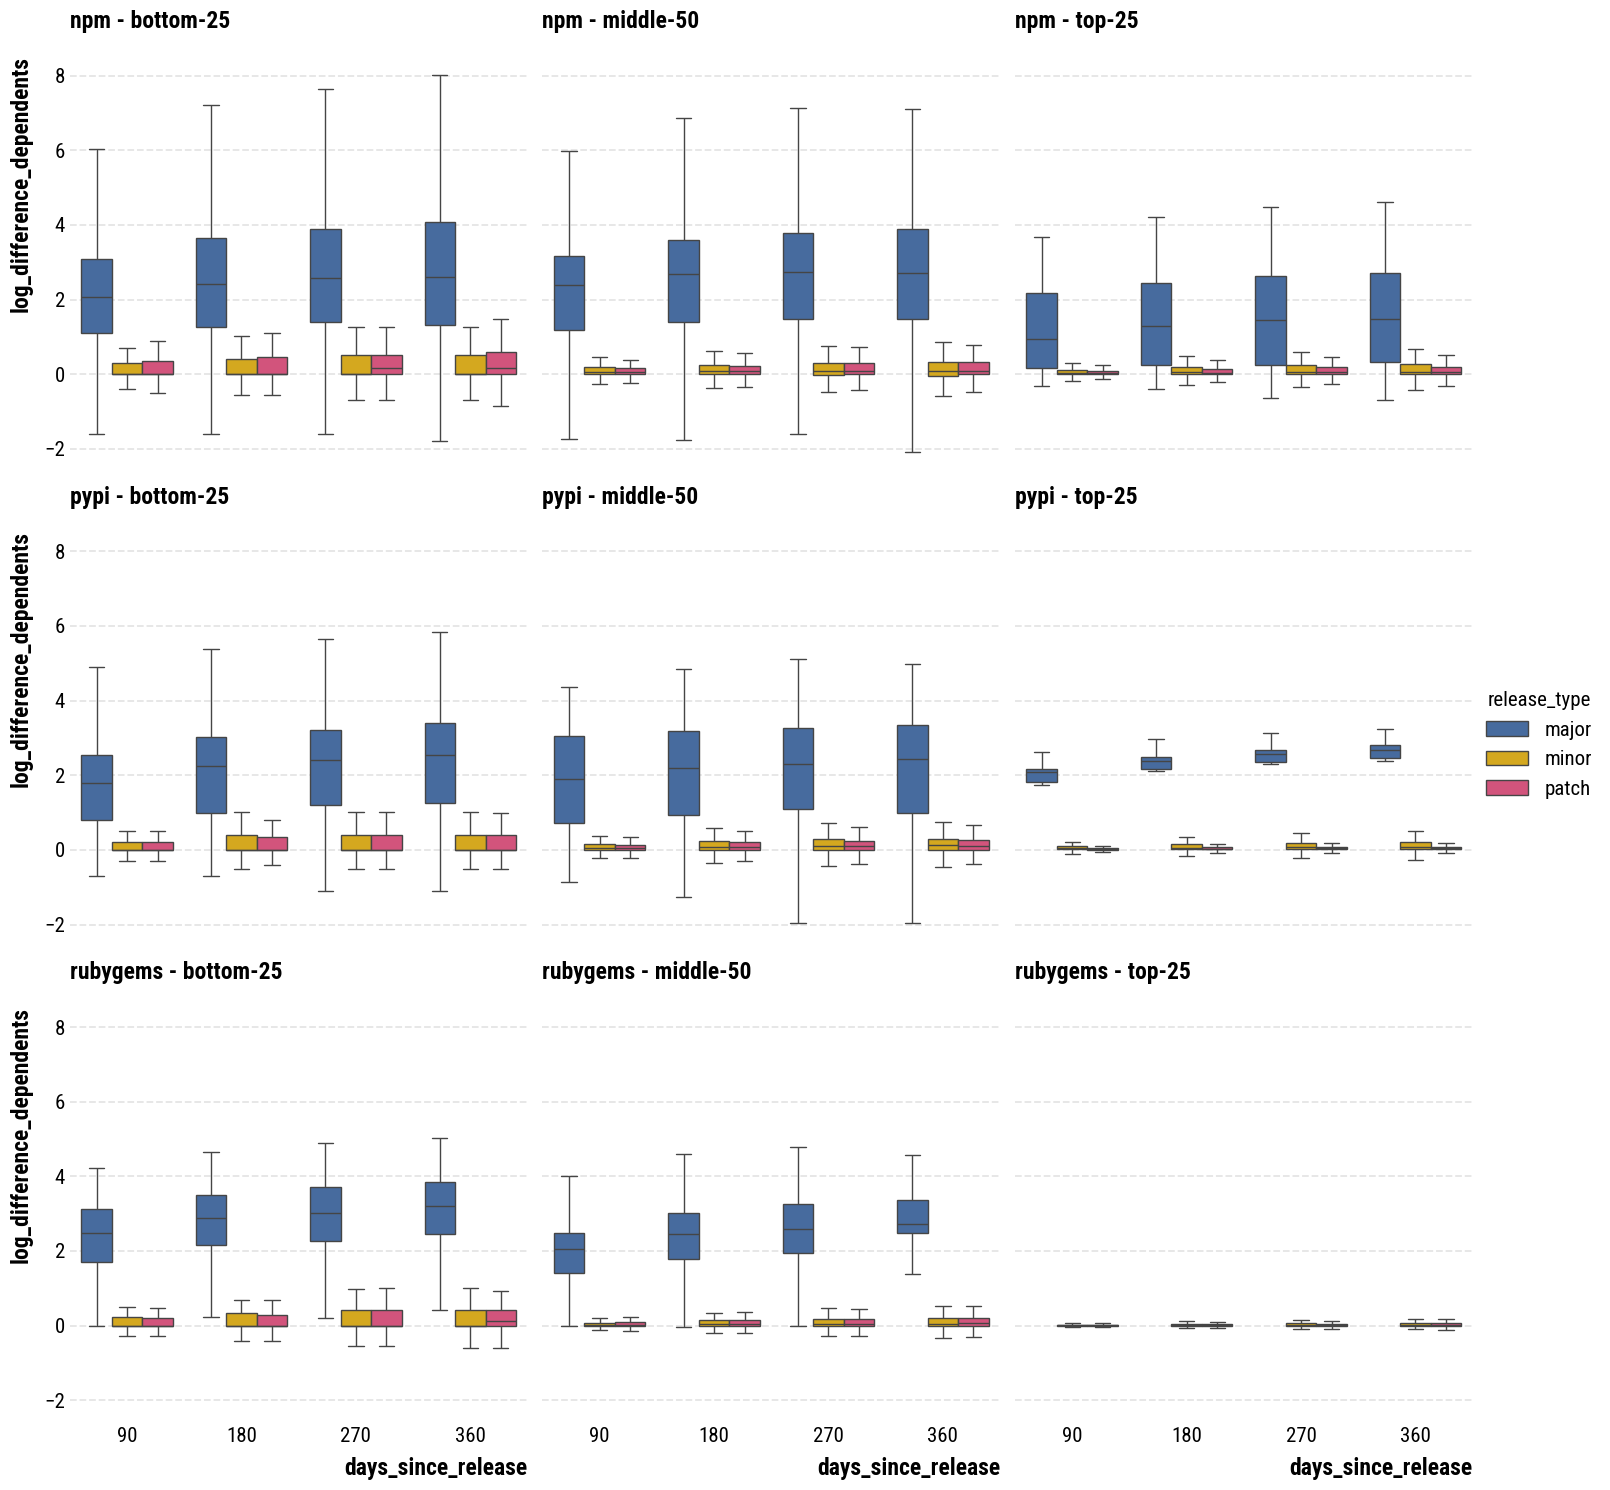

In [14]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_dependents_" in col_name
]

# Calculate log difference in dependents
constructed_exprs = []
for col_name in selected_columns:
    # Ignore the 0 day
    if col_name == "num_dependents_on_release_date":
        continue

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                pl.when(pl.col("num_dependents_on_release_date").gt(pl.lit(0)))
                .then(
                    (
                        pl.col(col_name).log()
                        - pl.col("num_dependents_on_release_date").log()
                    )
                )
                .otherwise(
                    pl.lit(0),
                )
            ).alias(f"log_difference_dependents_{timedelta_int}_days")
        )

# Create new column for log difference stars
log_diff_dependents_ecosystem_release_type = (
    lazy_frame.filter(
        pl.col("normalized_package_manager").is_in(["npm", "pypi", "rubygems"])
    )
    .filter(pl.col("release_type") != "unknown")
    .filter(pl.col("num_dependents_on_release_date").gt(pl.lit(1)))
    .select(
        pl.col("package_uuid"),
        pl.col("package_version"),
        pl.col("package_major_version"),
        pl.col("normalized_package_manager"),
        pl.col("release_type"),
        # Quantile bins for num_dependents
        pl.col("num_dependents_on_release_date")
        .qcut(
            [0.25, 0.75],
            labels=["bottom-25", "middle-50", "top-25"],
        )
        .over("normalized_package_manager")
        .alias("num_dependents_quantile"),
        # Version series bins
        pl.when(
            pl.col("release_type").is_in(["zero-major", "zero-minor"]),
        )
        .then(pl.lit("zero-ver"))
        .when(
            pl.col("package_major_version").eq(pl.lit(1)),
        )
        .then(pl.lit("one-ver"))
        .otherwise(pl.lit("two-plus-ver"))
        .alias("version_series"),
        *constructed_exprs,
    )
    .unpivot(
        index=[
            "package_uuid",
            "normalized_package_manager",
            "release_type",
            "package_version",
            "package_major_version",
            "num_dependents_quantile",
            "version_series",
        ],
        variable_name="days_since_release",
        value_name="log_difference_dependents",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(
            r"^(log_difference_dependents_)(\d+)(_days)$",
            r"$2",
        )
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

# Plot pct growth dependents
g = sns.catplot(
    data=log_diff_dependents_ecosystem_release_type,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="normalized_package_manager",
    row_order=["npm", "pypi", "rubygems"],
    col="num_dependents_quantile",
    col_order=["bottom-25", "middle-50", "top-25"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

### Log Difference in Dependents by Package Ecosystem and by Release Series

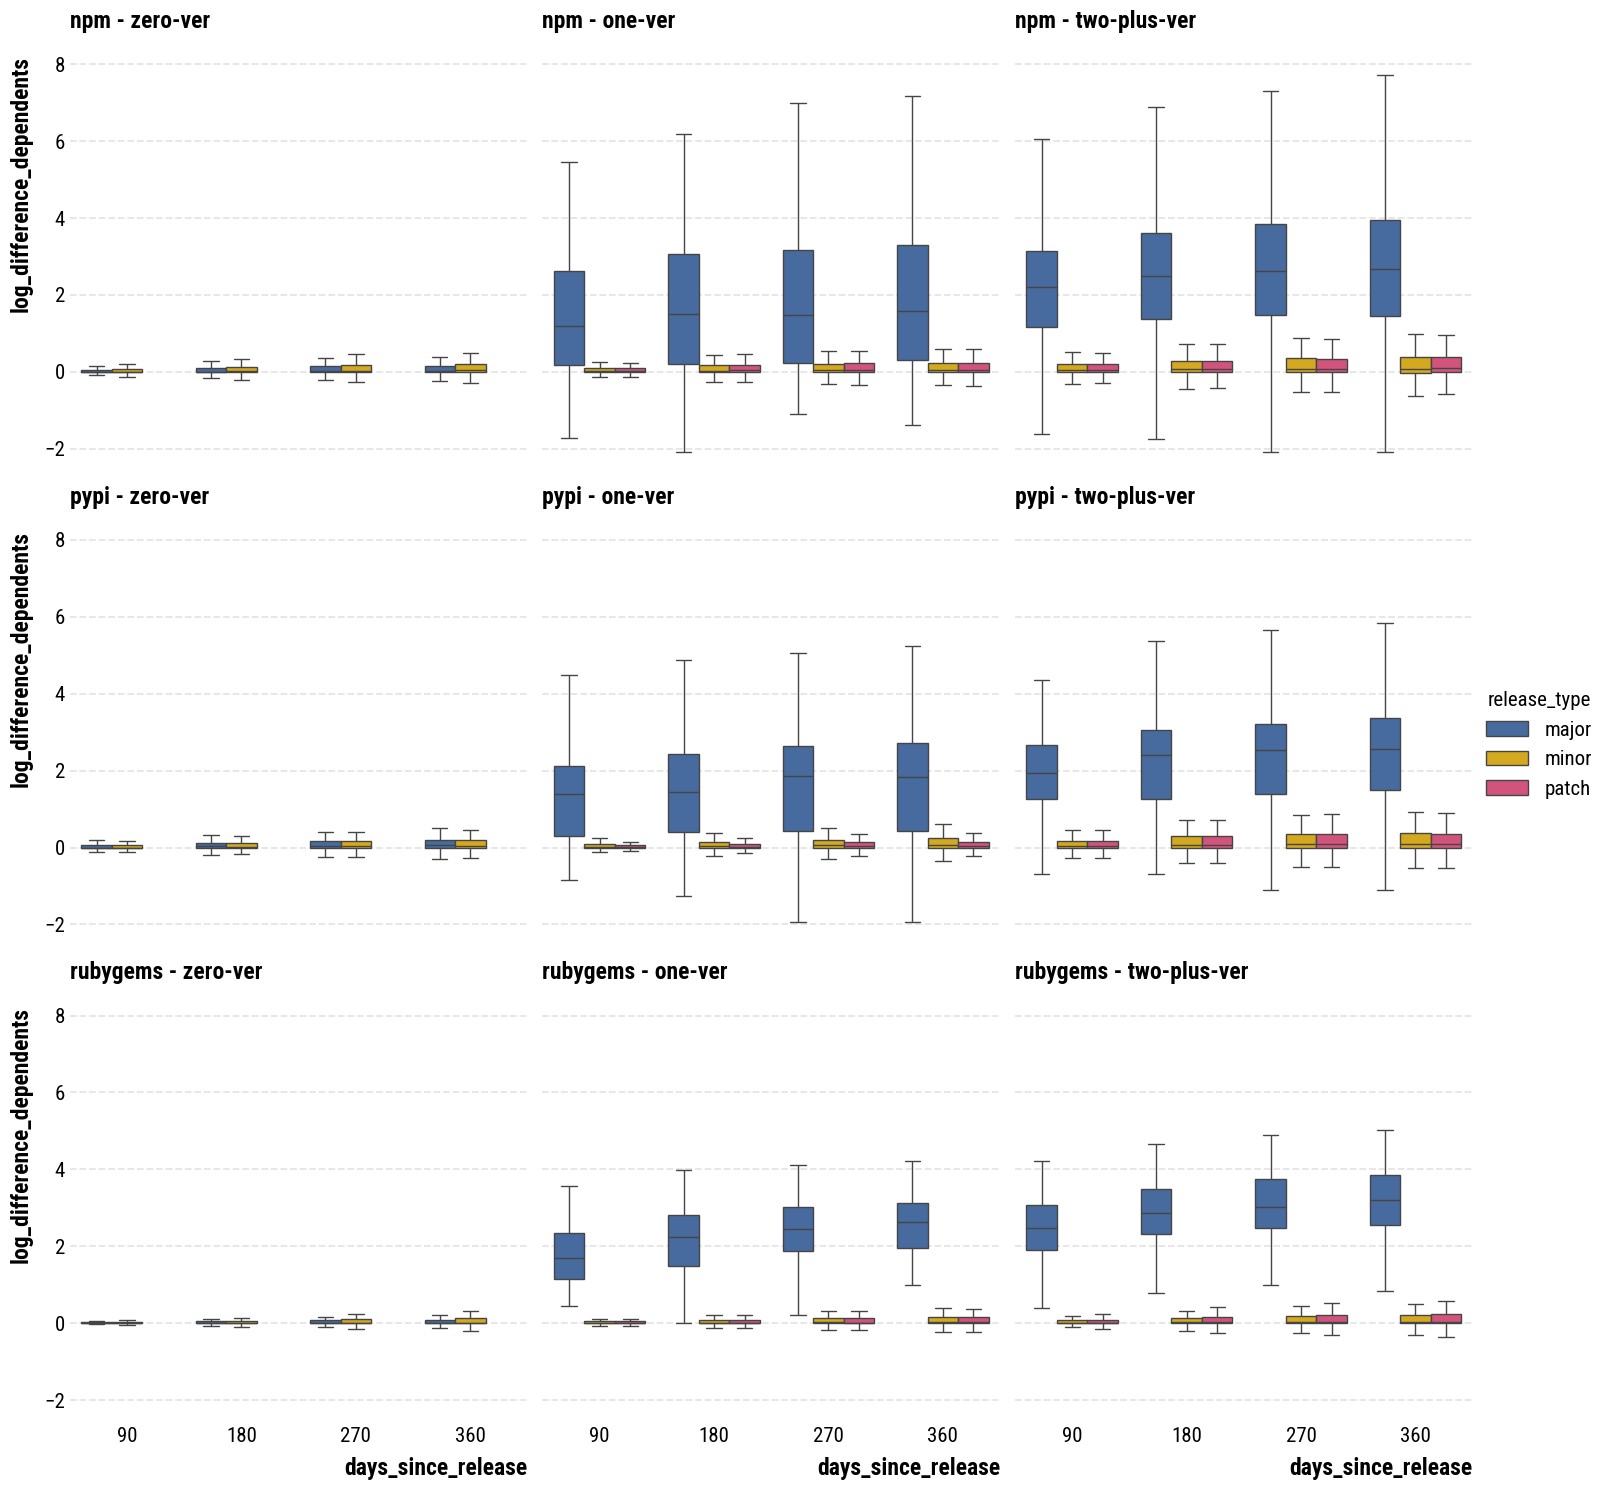

In [15]:
# Replace zero-ver release types
log_diff_dependents_ecosystem_release_type_replaced_zero_ver = (
    log_diff_dependents_ecosystem_release_type.select(
        pl.all().exclude("release_type"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
    )
)

# Plot pct growth dependents
g = sns.catplot(
    data=log_diff_dependents_ecosystem_release_type_replaced_zero_ver,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="normalized_package_manager",
    row_order=["npm", "pypi", "rubygems"],
    col="version_series",
    col_order=["zero-ver", "one-ver", "two-plus-ver"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")